In [1]:
#To Do:
#Explore feature selection/importance
#Investigate which scaler to use in more depth
#Test different models and hyperparameters for in depth understanding
#Explore different evaluation metrics
#Test different algorithms for predicting exogenous variables
#Hyperparameter tuning
#Set up automatic data gathering tasks.
#Document this project on Github.

#See https://www.geeksforgeeks.org/how-to-perform-ordinal-encoding-using-sklearn/
#Prophet performance_metrics function - rolling window after sorting by horizon (I think that is why the horizon starts at 0 days 18:00:00 when I set
#the window to 0.1). The function apparently always averages across cutoffs (see https://github.com/facebook/prophet/issues/1773), which I think makes
#sense because rolling window of 0 seems to be the average of the cutoffs when I tested because it starts at day 0 00:00:00, but additionally performs
#rolling average across horizon (each individual test point time mark?). I assume that the first window is the first horizon that completes at or
#beyond the window size starting from the first test point sorted by horizon and consequent windows ends at the end of the horizon following this
#first horizon that the first window stopped at - to know for sure I think I would need to calculate the metrics and/or look for the code.
#Not running hyperparameter tuning for multivariate prophet model because the univariate is taking a very long time to tune - maybe can try with less
#hyperparameter values but also see comment below.
#Prophet cross validation may be using the values for additonal regressors provided in the dataset for values from cutoff to horizon in the predictions
#which could increase model accuracy - I think to change this I would need to fit the model on data where the additional regressors are predicted
#as opposed to their true values but then this would cause some of the points before all but the first cutoff to be predicted values as opposed to true
#values which I think would decrease performance.
#For parallel processing the for loop for 1 hour predictions - I think adding one row at a time and using this combined dataframe would require the
#previous iteration to complete because it needs to use the dataframe from the previous iteration to add to so I think I would have to implement a
#lock. Therefore, I have just add the number of rows to the dataframe based on the iteration number which I think would not require any waiting.
#It seems for multiprocessing to work in Jupyter Notebook, need to define function in a separate .py file.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.fft import fft
import pywt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
import multiprocessing
from functools import partial
import functions

filepath = r'C:\Users\1026664\OneDrive - Blue Yonder\Documents\Machine Learning\AO Detection Time Forecasting\AOTA_DE_PROD.csv'
data = pd.read_csv(filepath, index_col='datehour')
data.index = pd.to_datetime(data.index,format='%d/%m/%Y %H:%M')
data_test = data[-672:-504]
data = data[:-672] #separate a week for data for validation.
print(data.shape)

(3096, 4)


In [3]:
data.fillna(0, inplace=True)

In [4]:
#outlier detection and removal
# order_time
mean = np.mean(data['order_time'])
std = np.std(data['order_time'])
#print('mean of the dataset is', mean)
#print('std. deviation is', std)
threshold = 3
outliers = data[abs(data['order_time'] - mean)/std > threshold]
#print('outlier in dataset is\n', outliers)
data.drop(data[abs(data['order_time'] - mean)/std > threshold].index, inplace=True)

# actual_orders
mean = np.mean(data['actual_orders'])
std = np.std(data['actual_orders'])
#print('mean of the dataset is', mean)
#print('std. deviation is', std)
threshold = 4
outliers = data[abs(data['actual_orders'] - mean)/std > threshold]
#print('outlier in dataset is\n', outliers)
data.drop(data[abs(data['actual_orders'] - mean)/std > threshold].index, inplace=True)

# detection_time
mean = np.mean(data['detection_time'])
std = np.std(data['detection_time'])
#print('mean of the dataset is', mean)
#print('std. deviation is', std)
threshold = 4
outliers = data[abs(data['detection_time'] - mean)/std > threshold]
#print('outlier in dataset is\n', outliers)
data.drop(data[abs(data['detection_time'] - mean)/std > threshold].index, inplace=True)

# Didn't apply outlier detection and removal to no_of_items because the line graph doesn't seem to have points that seem to be very different.

In [5]:
#Feature Engineering:
#Time based
#Fourier Transform
#Lags
#wavelet transform
#derivaties
#decomposition

In [6]:
data['dettime_lag1'] = data['detection_time'].shift(1)
data['dettime_lag2'] = data['detection_time'].shift(2)
data['dettime_lag3'] = data['detection_time'].shift(3)

In [7]:
data.drop(['2024-06-14 00:00:00','2024-06-14 01:00:00','2024-06-14 02:00:00'], inplace=True)

In [8]:
# Extract the day of the week from the date column
data['datehour'] = data.index
data['day_of_week'] = data['datehour'].dt.day_name()

# Create a new binary column for whether the day is a weekend or not
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
label_encoder = LabelEncoder() 
data['day_of_week_label']= label_encoder.fit_transform(data['day_of_week'])
data.drop(['day_of_week'], axis=1, inplace=True)

data['hour_of_day'] = data['datehour'].dt.hour
data.drop(['datehour'], axis=1, inplace=True)

In [9]:
#print(data[:144])

In [10]:
#fourier transformation
# Perform Fast Fourier Transform (FFT)
fft_values = fft(data['detection_time'])

# Get the magnitude and frequencies
fft_magnitude = np.abs(fft_values)
frequencies = np.fft.fftfreq(len(data['detection_time']))
data['fft_magnitude']=fft_magnitude
data['frequencies']=frequencies

In [11]:
#wavelet transformation
# Decompose the time series using wavelet transform
# Break down the data into different frequency components using wavelet transform
coeffs = pywt.wavedec(data['detection_time'], 'db4', level=3)

# Reconstruct the smoothed version of the time series from the decomposition
approx = pywt.upcoef('a', coeffs[-1], 'db4', level=3, take=len(data['detection_time']))
data['wavelet']=approx

In [12]:
#first derivative
data['det_derivative']=data['detection_time'].diff()
data.dropna(inplace=True)

In [13]:
# Decompose the time series - additive model because detection_time seems to have a rough normal distribtion according to my analysis???
decomposition = seasonal_decompose(data['detection_time'], period=24, model='additive',extrapolate_trend='freq')

# Extract and plot the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

data['trend_manual']=trend
data['seasonal_manual']=seasonal
data['residual_manual']=residual

In [14]:
data_target_train = data['detection_time']
data_features_train = data.loc[:, data.columns != 'detection_time']

ct = ColumnTransformer(
    [("standardscaler", StandardScaler(), ~data_features_train.columns.isin(['is_weekend','hour_of_day','day_of_week_label']))],remainder='passthrough',verbose_feature_names_out=False).set_output(transform="pandas")
data_features_train=ct.fit_transform(data_features_train)

In [15]:
print(data_features_train.columns)

Index(['order_time', 'actual_orders', 'no_of_items', 'dettime_lag1',
       'dettime_lag2', 'dettime_lag3', 'fft_magnitude', 'frequencies',
       'wavelet', 'det_derivative', 'trend_manual', 'seasonal_manual',
       'residual_manual', 'is_weekend', 'day_of_week_label', 'hour_of_day'],
      dtype='object')


**Univariate Time Series Forecasting with Facebook Prophet**

In [16]:
df_train_prophet = data_features_train.copy()
df_train_prophet['datehour']=df_train_prophet.index
df_train_prophet['y']=data_target_train

# date variable needs to be named "ds" for prophet
df_train_prophet = df_train_prophet.rename(columns={"datehour": "ds"})

model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)

df_future = model_prophet.make_future_dataframe(periods=168, freq='h')

forecast_prophet = model_prophet.predict(df_future)
#forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round()

13:27:14 - cmdstanpy - INFO - Chain [1] start processing
13:27:16 - cmdstanpy - INFO - Chain [1] done processing


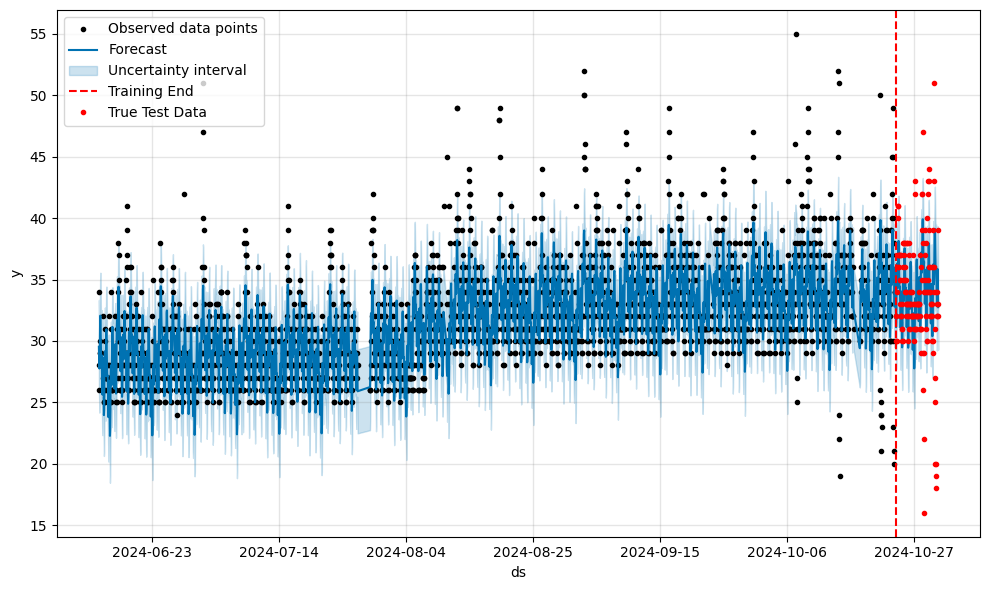

In [17]:
# plot the time series 
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-168]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
data_test['datehour'] = data_test.index
plt.plot(data_test['datehour'], data_test['detection_time'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()

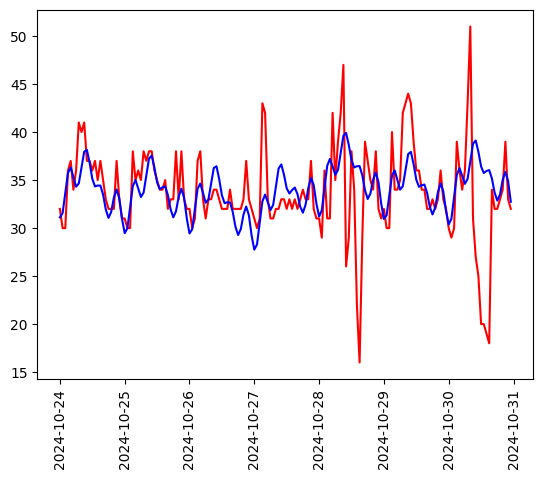

In [18]:
uni_data_test=data_test.merge(forecast_prophet,left_index=True,right_on='ds')

plt.plot(uni_data_test['datehour'],uni_data_test["detection_time"], color='red')
plt.plot(uni_data_test['datehour'],uni_data_test['yhat'], color='blue')
plt.xticks(rotation=90)
plt.show()

In [19]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(uni_data_test["detection_time"], uni_data_test['yhat'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate the Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(uni_data_test["detection_time"], uni_data_test['yhat'])
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Calculate the Median Absolute Percentage Error (MDAPE)
mdape = np.median(np.abs((uni_data_test["detection_time"] - uni_data_test['yhat'])/ uni_data_test["detection_time"]))*100
print(f"Median Absolute Percentage Error (MDAPE): {mdape:.4f}")

# Calculate the Geometric Mean Relative Absolute Error (GMRAE)
gmrae =np.prod(np.abs((uni_data_test["detection_time"] - uni_data_test['yhat'])/ uni_data_test["detection_time"]) ** (1/len(uni_data_test["detection_time"])))*100
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae:.4f}")

Mean Absolute Error (MAE): 2.9546
Root Mean Squared Error (RMSE): 4.7924
Median Absolute Percentage Error (MDAPE): 5.0080
Geometric Mean Relative Absolute Error (GMRAE): 4.4632


**Multivariate Time Series using Facebook Prophet**

'order_time', 'actual_orders', 'no_of_items', 'dettime_lag1',
       'dettime_lag2', 'dettime_lag3', 'fft_magnitude', 'frequencies',
       'wavelet', 'det_derivative', 'trend', 'seasonal', 'residual',
       'is_weekend', 'hour_of_day', 'day_of_week_label'

In [20]:
multi_model_prophet  = Prophet()
multi_model_prophet.add_regressor('order_time',standardize=False)
multi_model_prophet.add_regressor('actual_orders',standardize=False)
multi_model_prophet.add_regressor('no_of_items',standardize=False)
multi_model_prophet.add_regressor('dettime_lag1',standardize=False)
multi_model_prophet.add_regressor('dettime_lag2',standardize=False)
multi_model_prophet.add_regressor('dettime_lag3',standardize=False)
multi_model_prophet.add_regressor('fft_magnitude',standardize=False)
multi_model_prophet.add_regressor('frequencies',standardize=False)
multi_model_prophet.add_regressor('wavelet',standardize=False)
multi_model_prophet.add_regressor('det_derivative',standardize=False)
multi_model_prophet.add_regressor('trend_manual',standardize=False)
multi_model_prophet.add_regressor('seasonal_manual',standardize=False)
multi_model_prophet.add_regressor('residual_manual',standardize=False)
multi_model_prophet.add_regressor('is_weekend',standardize=False)
multi_model_prophet.add_regressor('hour_of_day',standardize=False)
multi_model_prophet.add_regressor('day_of_week_label',standardize=False)
multi_model_prophet.fit(df_train_prophet)

multi_df_future = multi_model_prophet.make_future_dataframe(periods=168, freq='h')

13:27:19 - cmdstanpy - INFO - Chain [1] start processing
13:27:28 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
print(multi_df_future)

                      ds
0    2024-06-14 04:00:00
1    2024-06-14 05:00:00
2    2024-06-14 06:00:00
3    2024-06-14 07:00:00
4    2024-06-14 08:00:00
...                  ...
3204 2024-10-30 19:00:00
3205 2024-10-30 20:00:00
3206 2024-10-30 21:00:00
3207 2024-10-30 22:00:00
3208 2024-10-30 23:00:00

[3209 rows x 1 columns]


In [22]:
#forecast additional variables because these would not be known in advance
data_features_train['ds']=data_features_train.index
multi_df_future['day_of_week'] = multi_df_future['ds'].dt.day_name()
multi_df_future['is_weekend'] = multi_df_future['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
multi_df_future['hour_of_day'] = multi_df_future['ds'].dt.hour
multi_df_future['day_of_week_label']= label_encoder.transform(multi_df_future['day_of_week'])
multi_df_future.drop(['day_of_week'], axis=1, inplace=True)
for i in list(data_features_train.drop(['ds','is_weekend','day_of_week_label','hour_of_day'],axis=1).columns):
    temp_train_prophet = data_features_train[['ds',i]].copy()
    temp_train_prophet = temp_train_prophet.rename(columns={i: "y"})
    temp_model_prophet  = Prophet()
    temp_model_prophet.fit(temp_train_prophet)
    temp_future = temp_model_prophet.make_future_dataframe(periods=168, freq='h')
    temp_forecast_prophet = temp_model_prophet.predict(temp_future)
    temp_forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round()
    multi_df_future[i]=temp_forecast_prophet['yhat'].copy()
print(multi_df_future)

13:27:29 - cmdstanpy - INFO - Chain [1] start processing
13:27:29 - cmdstanpy - INFO - Chain [1] done processing
13:27:30 - cmdstanpy - INFO - Chain [1] start processing
13:27:31 - cmdstanpy - INFO - Chain [1] done processing
13:27:32 - cmdstanpy - INFO - Chain [1] start processing
13:27:32 - cmdstanpy - INFO - Chain [1] done processing
13:27:33 - cmdstanpy - INFO - Chain [1] start processing
13:27:34 - cmdstanpy - INFO - Chain [1] done processing
13:27:35 - cmdstanpy - INFO - Chain [1] start processing
13:27:35 - cmdstanpy - INFO - Chain [1] done processing
13:27:36 - cmdstanpy - INFO - Chain [1] start processing
13:27:37 - cmdstanpy - INFO - Chain [1] done processing
13:27:38 - cmdstanpy - INFO - Chain [1] start processing
13:27:39 - cmdstanpy - INFO - Chain [1] done processing
13:27:40 - cmdstanpy - INFO - Chain [1] start processing
13:27:41 - cmdstanpy - INFO - Chain [1] done processing
13:27:42 - cmdstanpy - INFO - Chain [1] start processing
13:27:43 - cmdstanpy - INFO - Chain [1]

                      ds  is_weekend  hour_of_day  day_of_week_label  \
0    2024-06-14 04:00:00           0            4                  0   
1    2024-06-14 05:00:00           0            5                  0   
2    2024-06-14 06:00:00           0            6                  0   
3    2024-06-14 07:00:00           0            7                  0   
4    2024-06-14 08:00:00           0            8                  0   
...                  ...         ...          ...                ...   
3204 2024-10-30 19:00:00           0           19                  6   
3205 2024-10-30 20:00:00           0           20                  6   
3206 2024-10-30 21:00:00           0           21                  6   
3207 2024-10-30 22:00:00           0           22                  6   
3208 2024-10-30 23:00:00           0           23                  6   

      order_time  actual_orders  no_of_items  dettime_lag1  dettime_lag2  \
0      -0.575071      -0.775574    -0.548788     -0.650540 

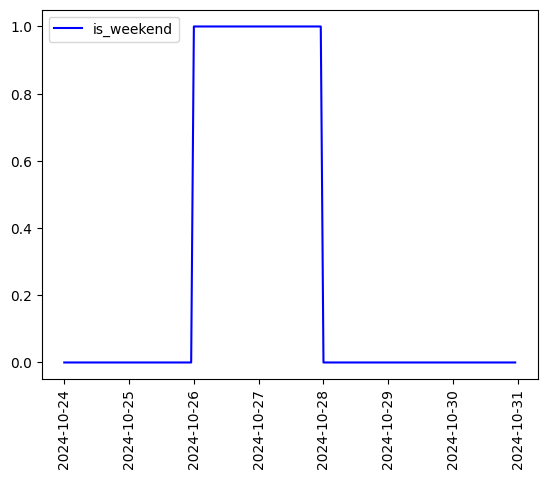

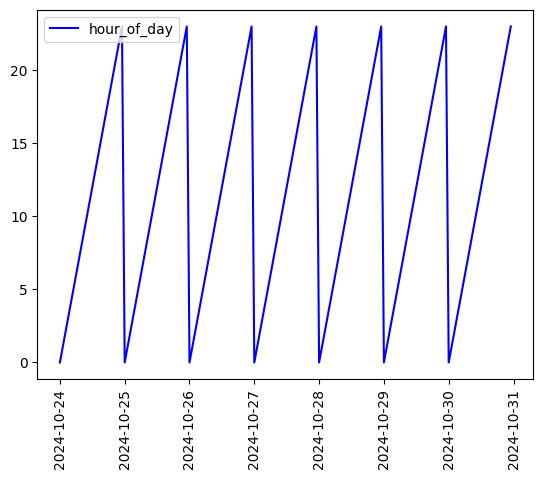

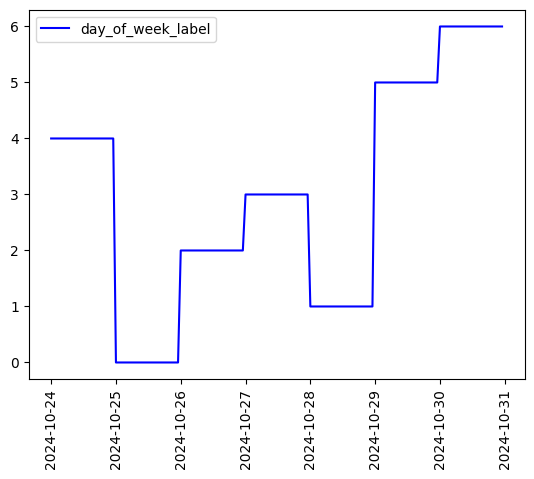

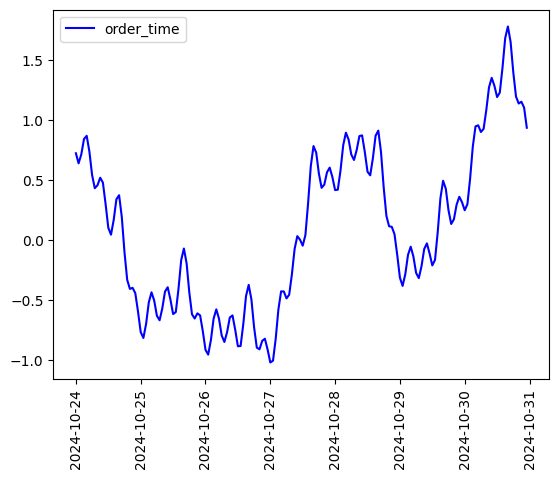

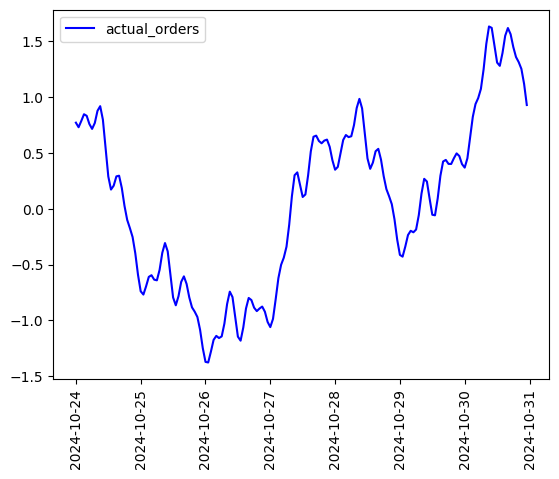

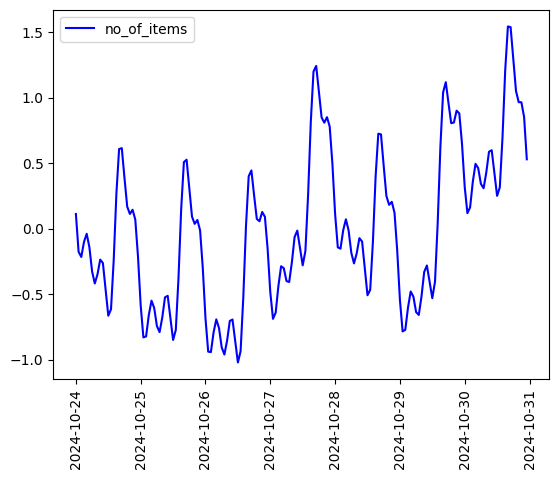

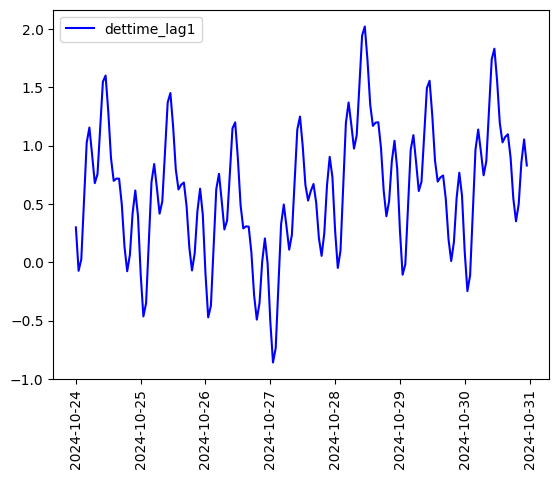

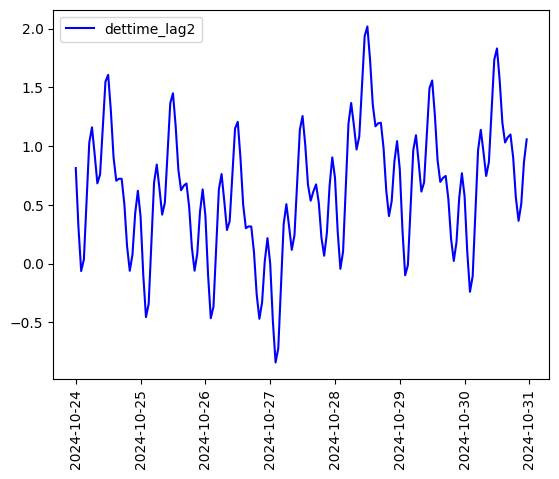

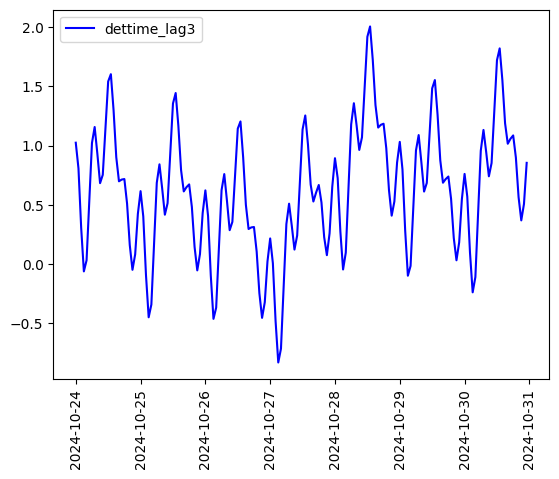

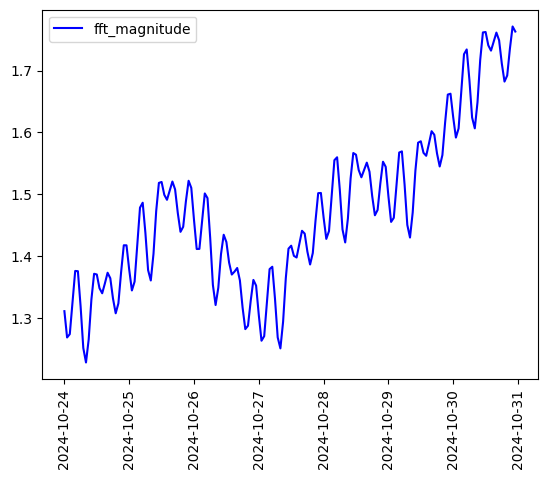

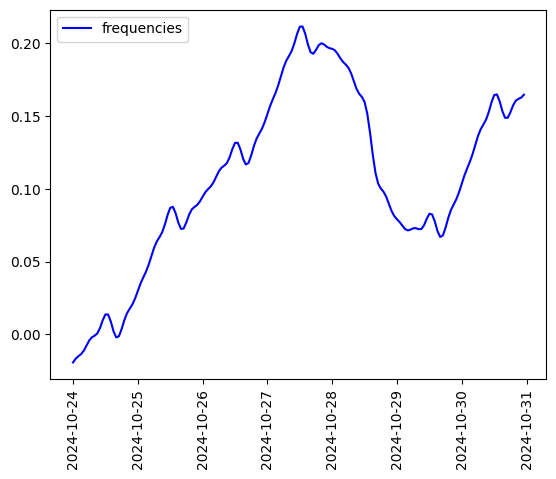

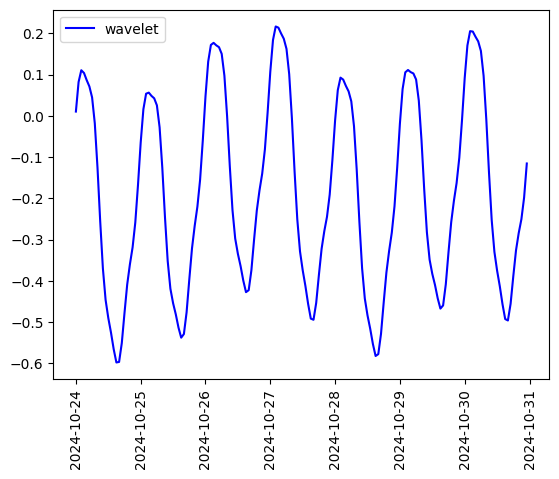

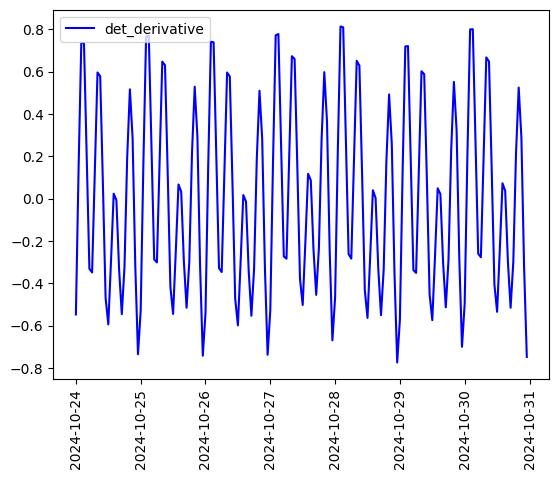

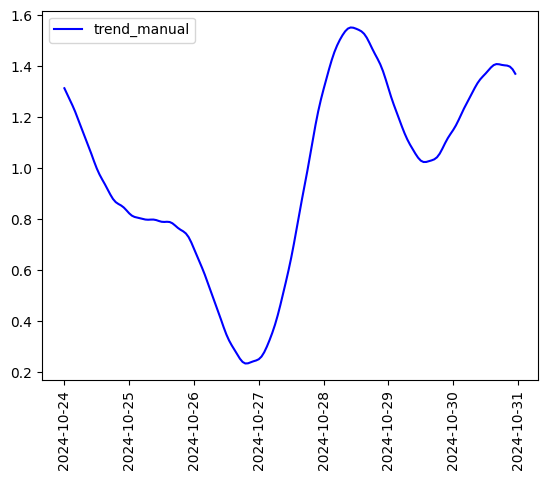

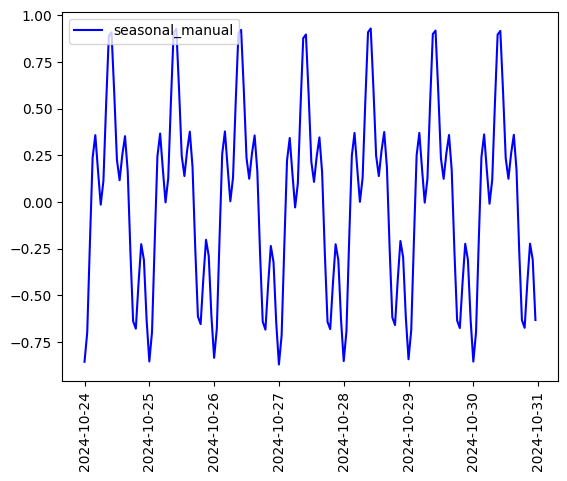

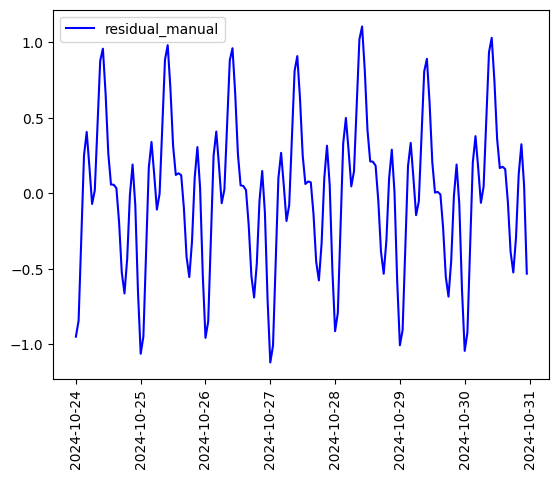

In [23]:
#plot these additional variable prediction graphs
for i in list(multi_df_future.drop('ds',axis=1).columns):
    plt.plot(multi_df_future['ds'][-168:],multi_df_future[i][-168:], color='blue', label=i)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.show()

In [24]:
multi_forecast_prophet = multi_model_prophet.predict(multi_df_future)
#multi_forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round()

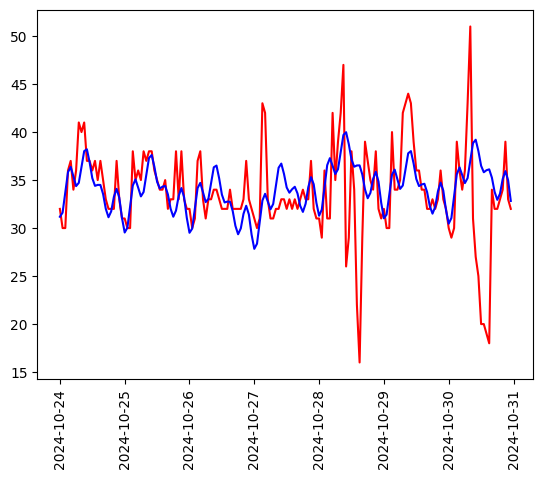

In [25]:
multi_data_test=data_test.merge(multi_forecast_prophet,left_index=True,right_on='ds')

plt.plot(multi_data_test['datehour'],multi_data_test["detection_time"], color='red')
plt.plot(multi_data_test['datehour'],multi_data_test['yhat'], color='blue')
plt.xticks(rotation=90)
plt.show()

In [26]:
# Calculate Mean Absolute Error (MAE)
multi_mae = mean_absolute_error(multi_data_test["detection_time"], multi_data_test['yhat'])
print(f"Mean Absolute Error (MAE): {multi_mae:.4f}")

# Calculate the Root Mean Squared Error (RMSE)
multi_rmse = root_mean_squared_error(multi_data_test["detection_time"], multi_data_test['yhat'])
print(f"Root Mean Squared Error (RMSE): {multi_rmse:.4f}")

# Calculate the Median Absolute Percentage Error (MDAPE)
multi_mdape = np.median(np.abs((multi_data_test["detection_time"] - multi_data_test['yhat'])/ multi_data_test["detection_time"]))*100
print(f"Median Absolute Percentage Error (MDAPE): {multi_mdape:.4f}")

# Calculate the Geometric Mean Relative Absolute Error (GMRAE)
multi_gmrae =np.prod(np.abs((multi_data_test["detection_time"] - multi_data_test['yhat'])/ multi_data_test["detection_time"]) ** (1/len(multi_data_test["detection_time"])))*100
print(f"Geometric Mean Relative Absolute Error (GMRAE): {multi_gmrae:.4f}")

Mean Absolute Error (MAE): 2.9559
Root Mean Squared Error (RMSE): 4.7983
Median Absolute Percentage Error (MDAPE): 4.9272
Geometric Mean Relative Absolute Error (GMRAE): 4.5859


In [27]:
#see above for suspected reason why performance of multivariate model using prophet cross validation seems to be much more accurate
df_cv = cross_validation(multi_model_prophet, initial='504 hours', period='84 hours', horizon = '168 hours',parallel="processes")
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 18:00:00,0.000300,0.017307,0.006804,0.000234,0.000085,0.000234,0.949955
1,0 days 19:00:00,0.000333,0.018245,0.007168,0.000247,0.000087,0.000247,0.945797
2,0 days 20:00:00,0.000365,0.019102,0.007494,0.000256,0.000087,0.000256,0.941639
3,0 days 21:00:00,0.000398,0.019945,0.007834,0.000265,0.000089,0.000265,0.937481
4,0 days 22:00:00,0.000431,0.020755,0.008169,0.000272,0.000090,0.000272,0.933175


In [28]:
#Trying to understand the performance_metrics function above
df_cv['horizon']=df_cv['ds']-df_cv['cutoff']
#print(df_cv.sort_values(by=['horizon'])[522:])

In [29]:
# #hyperparameter tuning - univariate model
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'seasonality_mode': ['additive','multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# uni_rmses = []  # Store the RMSEs for each params here

# cutoffs = pd.to_datetime(['2024-08-01', '2024-09-15', '2024-10-10'])

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df_train_prophet)  # Fit model with given params
#     temp_df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '168 hours', parallel="processes")
#     temp_df_p = performance_metrics(temp_df_cv, rolling_window=1)
#     uni_rmses.append(temp_df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = uni_rmses
# print(tuning_results)
# best_params = all_params[np.argmin(uni_rmses)]
# print(best_params)
# print('best rmse: '+str(min(uni_rmses)))

**Univariate Model 1 Hour Forecast - it seems this is not much different from forecasting a full week ahead**

In [30]:
df_train_prophet_1_hour = data[['detection_time']].copy()
df_train_prophet_1_hour['datehour']=df_train_prophet_1_hour.index
df_train_prophet_1_hour = df_train_prophet_1_hour.rename(columns={"datehour": "ds","detection_time":"y"})

df_test_prophet_1_hour = data_test[['detection_time']].copy()
df_test_prophet_1_hour['datehour']=df_test_prophet_1_hour.index
df_test_prophet_1_hour = df_test_prophet_1_hour.rename(columns={"datehour": "ds","detection_time":"y"})

with multiprocessing.Pool() as pool:
    predictions = pool.map(partial(functions.forecast_1_hour, train_df=df_train_prophet_1_hour, test_df=df_test_prophet_1_hour), range(0,len(df_test_prophet_1_hour)))

predictions_df = pd.DataFrame(predictions,columns=['yhat'])
predictions_df['ds'] = df_test_prophet_1_hour.index

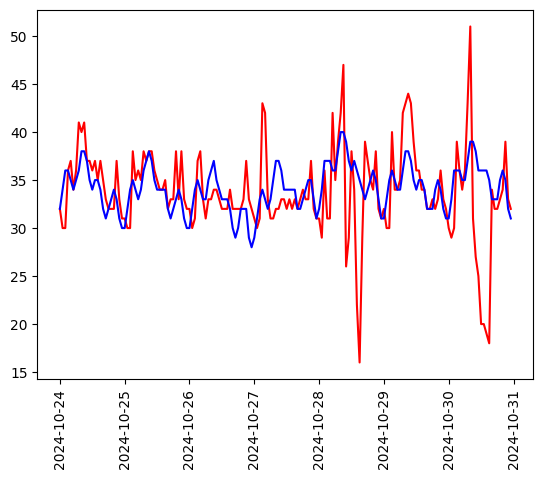

In [31]:
test_predictions_1_hour=data_test.merge(predictions_df,left_index=True,right_on='ds')

plt.plot(test_predictions_1_hour['ds'],test_predictions_1_hour["detection_time"], color='red')
plt.plot(test_predictions_1_hour['ds'],test_predictions_1_hour['yhat'], color='blue')
plt.xticks(rotation=90)
plt.show()